In [3]:
from autogluon.tabular import TabularDataset, TabularPredictor

import sklearn.metrics as skm
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import random
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

random_seed = 29

class_list = [
    'zero',
    'mm_1',
    # 'mm_1_out',
    'first',
    'mm_2',
    'second',
]

ag_model_root = './AutogluonModels/'

In [5]:
def draw_fig(data_id, raw_data, sp_mode, legend=False, title=False, alpha=0.1):
    if sp_mode == 'sp':
        y_1 = raw_data[raw_data['id'] == data_id].iloc[:, 1:31].values[0]
        y_2 = raw_data[raw_data['id'] == data_id].iloc[:, 31:].values[0]
        # cat_conc = raw_data[raw_data['id'] == data_id].iloc[:, 1].values[0]
        x = np.arange(1, 31)
        plt.plot(x, y_1, label='s')
        plt.plot(x, y_2, label='p')
        plt.ylim(0, 1.1)
        if title:
            plt.title(f'{data_id}')
        if legend:
            plt.legend()
        # plt.show()
    elif sp_mode == 's' or sp_mode == 'p':
        y = raw_data[raw_data['id'] == data_id].iloc[:, 1:31].values[0]
        # cat_conc = raw_data[raw_data['id'] == data_id].iloc[:, 1].values[0]
        x = np.arange(1, 31)
        plt.plot(x, y, alpha=alpha, color='grey')
        plt.ylim(0, 1.1)
        if title:
            plt.title(f'{data_id}')
        # plt.show()

def draw_fig_from_json(data_id, p=True, bp=True, title=False, legend=False, A_cutoff=10**5, alpha=0.1, AaB_cutoff=0.005):
    old_class_name = data_id.split('-')[1]
    id_num = data_id.split('-')[-1]
    json_path = f'../Ye/previous/norm_cat/{old_class_name}/{id_num}.json'
    with open(json_path, 'r') as f:
        data = json.load(f)
    if data['A'] > A_cutoff:
        return
    if (data['a'] + data['B']) / data['A'] < AaB_cutoff:
        return
    x = np.arange(1, 31)
    s = data['s']
    plt.plot(x, s, label='s', alpha=alpha, color='grey')
    if p:
        p = data['p']
        plt.plot(x, p, label='p')
    if bp:
        bp = data['bp']
        plt.plot(x, bp, label='bp')
    plt.ylim(0, 1.1)
    if legend:
        plt.legend()
    if title:
        plt.title(data_id)

def draw_figs(data_id_list, raw_data, sp_mode):
    for data_id in data_id_list:
        draw_fig(data_id, raw_data, sp_mode)
    plt.show()

def collect_yields(data_id_list):
    s_yields = []
    p_yields = []
    bp_yields = []
    for data_id in tqdm(data_id_list):
        print(data_id)
        old_class_name = data_id.split('-')[1]
        id_num = data_id.split('-')[-1]
        json_path = f'../Ye/previous/norm_cat/{old_class_name}/{id_num}.json'
        with open(json_path, 'r') as f:
            data = json.load(f)

        s_yields.append(data['s'][-1])
        p_yields.append(data['p'][-1])
        bp_yields.append(data['bp'][-1])
        for k in data.keys():
            if k not in ['s', 'p', 'bp', 'cat', 'cats', 't']:
                print(f'{k}:', data[k])
    
    df = pd.DataFrame({
        # 'id': data_id_list + data_id_list + data_id_list,
        'yield': s_yields + p_yields + bp_yields,
        'src': ['s']*len(data_id_list) + ['p']*len(data_id_list) + ['bp']*len(data_id_list)
    })

    return df

## norm_cat / sp

In [30]:
cat_conc = 'norm_cat'
sp_mode = 'sp'

In [31]:
test_data_path = os.path.join(f'data/{cat_conc}', f'{cat_conc}_test_tsfresh_feat.csv')
test_data = pd.read_csv(test_data_path)
test_raw_data = pd.read_csv(os.path.join(f'data/{cat_conc}', f'{cat_conc}_test.csv'))
test_raw_data.drop(columns=['class'], inplace=True)
test_merge_data_sp = pd.merge(test_data, test_raw_data, on='id')
assert test_merge_data_sp.shape[0] == test_data.shape[0]
test_merge_data_s = test_merge_data_sp.drop(columns=[c for c in test_merge_data_sp.columns if c.startswith('p')])

if sp_mode == 'sp':
    test_merge_data = test_merge_data_sp
elif sp_mode == 's':
    test_merge_data = test_merge_data_s
else:
    raise ValueError('Wrong sp mode')

In [32]:
test_raw_data

id        s0        s1        s2        s3  \
0         mm_2-mm__double_inside-4  1.012360  0.933061  0.928267  0.866510   
1            first-0__double-12193  1.000383  0.925738  0.857736  0.812996   
2              zero-0__single-6260  1.000000  0.946205  0.902408  0.858611   
3             mm_2-mm__double-7685  0.974698  0.937942  0.917170  0.892031   
4              mm_1-mm__single-302  1.000000  0.936901  0.878418  0.823222   
...                            ...       ...       ...       ...       ...   
4995  first-0__double_outside-3625  1.019427  0.918633  0.815067  0.787875   
4996          mm_1-mm__single-6786  1.022219  0.950719  0.927502  0.916690   
4997        second-1__double-10114  1.000000  0.891006  0.798286  0.718057   
4998           zero-0__single-2144  1.000000  0.941137  0.892250  0.843369   
4999         mm_2-mm__double-10149  1.011469  0.892548  0.813922  0.734045   

            s4        s5        s6        s7        s8  ...       p21  \
0     0.823828  0.798407  0.760748  0.718613  0.688366  ...  0.257349   
1     0.721158  0.727759  0.653335  0.603084  0.560502  ...  0.257890   
2     0.814813  0.771015  0.727218  0.683423  0.639627  ...  0.919584   
3     0.816140  0.844044  0.770880  0.759987  0.709061  ...  0.210835   
4     0.771176  0.722122  0.675932  0.632467  0.591587  ...  0.757471   
...        ...       ...       ...       ...       ...  ...       ...   
4995  0.741732  0.681573  0.573220  0.559608  0.518452  ...  0.359748   
4996  0.858209  0.827925  0.820310  0.762408  0.754970  ...  0.662951   
4997  0.648172  0.586925  0.532954  0.485161  0.442651  ...  0.295910   
4998  0.794496  0.745626  0.696770  0.647920  0.599082  ...  0.999036   
4999  0.677147  0.614807  0.567414  0.512689  0.478938  ...  0.284454   

           p22       p23       p24       p25       p26       p27       p28  \
0     0.242121  0.247929  0.286189  0.270034  0.292008  0.311331  0.302836   
1     0.308120  0.310113  0.298817  0.314652  0.286273  0.319042  0.293099   
2     0.963290  0.998076  0.999975  1.000000  1.000000  1.000000  1.000000   
3     0.221682  0.245037  0.257680  0.216781  0.213721  0.237566  0.258720   
4     0.773889  0.789226  0.803549  0.816922  0.829405  0.841055  0.851925   
...        ...       ...       ...       ...       ...       ...       ...   
4995  0.313074  0.330983  0.372142  0.389571  0.389727  0.375211  0.349100   
4996  0.661413  0.703743  0.714643  0.741566  0.791446  0.824204  0.836441   
4997  0.297340  0.298573  0.299637  0.300556  0.301351  0.302039  0.302635   
4998  0.999989  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
4999  0.294970  0.293569  0.306213  0.298515  0.304066  0.292447  0.307524   

           p29          old_class  
0     0.307973  mm__double_inside  
1     0.335993          0__double  
2     1.000000          0__single  
3     0.269964         mm__double  
4     0.862064         mm__single  
...        ...                ...  
4995  0.389086  0__double_outside  
4996  0.868016         mm__single  
4997  0.303151          1__double  
4998  1.000000          0__single  
4999  0.301086         mm__double  

[5000 rows x 62 columns]

In [33]:
model_root = os.path.join(ag_model_root, f'{cat_conc}__tsfresh_raw_feat__{sp_mode}__best_quality')

predictor = TabularPredictor.load(model_root)
predictor.leaderboard()

model  score_val eval_metric  pred_time_val  \
0           WeightedEnsemble_L3   0.823644    accuracy      12.995657   
1          LightGBM_r131_BAG_L2   0.823022    accuracy      10.246614   
2          LightGBMLarge_BAG_L2   0.822844    accuracy      10.701418   
3               LightGBM_BAG_L2   0.822400    accuracy      10.235399   
4             LightGBMXT_BAG_L2   0.821622    accuracy      10.187645   
5          CatBoost_r177_BAG_L2   0.820333    accuracy      10.137298   
6               CatBoost_BAG_L2   0.819844    accuracy      10.068993   
7          LightGBMLarge_BAG_L1   0.819733    accuracy       3.148208   
8           WeightedEnsemble_L2   0.819733    accuracy       3.150788   
9             LightGBMXT_BAG_L1   0.817311    accuracy       2.472298   
10              LightGBM_BAG_L1   0.815378    accuracy       1.928650   
11              CatBoost_BAG_L1   0.812200    accuracy       0.401449   
12         LightGBM_r131_BAG_L1   0.796044    accuracy       0.423793   
13         CatBoost_r177_BAG_L1   0.783667    accuracy       0.311611   
14       NeuralNetFastAI_BAG_L1   0.200000    accuracy       1.030869   
15       NeuralNetFastAI_BAG_L2   0.200000    accuracy      11.023132   
16  NeuralNetFastAI_r191_BAG_L2   0.200000    accuracy      11.583352   

       fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   5035.261975                0.002688           3.519247            3   
1   3668.583112                0.529734         155.737071            2   
2   4075.205454                0.984538         562.359413            2   
3   3695.224758                0.518519         182.378717            2   
4   3612.137874                0.470766          99.291833            2   
5   3775.444829                0.420419         262.598788            2   
6   3769.376906                0.352114         256.530865            2   
7    871.400013                3.148208         871.400013            1   
8    873.652478                0.002579           2.252465            2   
9    294.434676                2.472298         294.434676            1   
10   385.322045                1.928650         385.322045            1   
11  1604.773147                0.401449        1604.773147            1   
12    28.708463                0.423793          28.708463            1   
13   167.330387                0.311611         167.330387            1   
14   160.877310                1.030869         160.877310            1   
15  3656.902587                1.306252         144.056546            2   
16  3571.938853                1.866472          59.092812            2   

    can_infer  fit_order  
0        True         17  
1        True         15  
2        True         13  
3        True         11  
4        True         10  
5        True         14  
6        True         12  
7        True          5  
8        True          8  
9        True          2  
10       True          3  
11       True          4  
12       True          7  
13       True          6  
14       True          1  
15       True          9  
16       True         16

In [34]:
test_merge_data_nolabel = test_merge_data.drop(columns=['class'])
y_test = test_merge_data['class']
y_pred = predictor.predict(test_merge_data_nolabel)
y_proba = predictor.predict_proba(test_merge_data_nolabel)

/home/zxhuang/anaconda3/envs/my_org_mech/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, downcast=False)
/home/zxhuang/anaconda3/envs/my_org_mech/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:180: RuntimeWarning: invalid value encountered in subtract
  (X[self.cont_columns].values - cont_mean) / cont_std,
/home/zxhuang/anaconda3/envs/my_org_mech/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast'

In [35]:
accuracy = skm.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
balanced_accuracy = skm.balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')
precision = skm.precision_score(y_test, y_pred, average='macro')
print(f'Precision: {precision}')
recall = skm.recall_score(y_test, y_pred, average='macro')
print(f'Recall: {recall}')
f1 = skm.f1_score(y_test, y_pred, average='macro')
print(f'F1: {f1}')
roc_auc = skm.roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f'ROC AUC: {roc_auc}')
prc_auc = skm.average_precision_score(y_test, y_proba, average='macro')
print(f'PRC AUC: {prc_auc}')
mcc = skm.matthews_corrcoef(y_test, y_pred)
print(f'MCC: {mcc}')
top_2_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=2)
print(f'Top-2 Accuracy: {top_2_accuracy}')
top_3_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=3)
print(f'Top-3 Accuracy: {top_3_accuracy}')
print('================================')
print(skm.classification_report(y_test, y_pred))

Accuracy: 0.8254
Balanced Accuracy: 0.8253999999999999
Precision: 0.8277001491960446
Recall: 0.8253999999999999
F1: 0.8241287474665544
ROC AUC: 0.97723885
PRC AUC: 0.9226754939685726
MCC: 0.7828717193423517
Top-2 Accuracy: 0.9702
Top-3 Accuracy: 1.0
              precision    recall  f1-score   support

       first       0.82      0.83      0.83      1000
        mm_1       0.91      0.79      0.85      1000
        mm_2       0.79      0.70      0.74      1000
      second       0.75      0.84      0.79      1000
        zero       0.86      0.96      0.91      1000

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.82      5000
weighted avg       0.83      0.83      0.82      5000



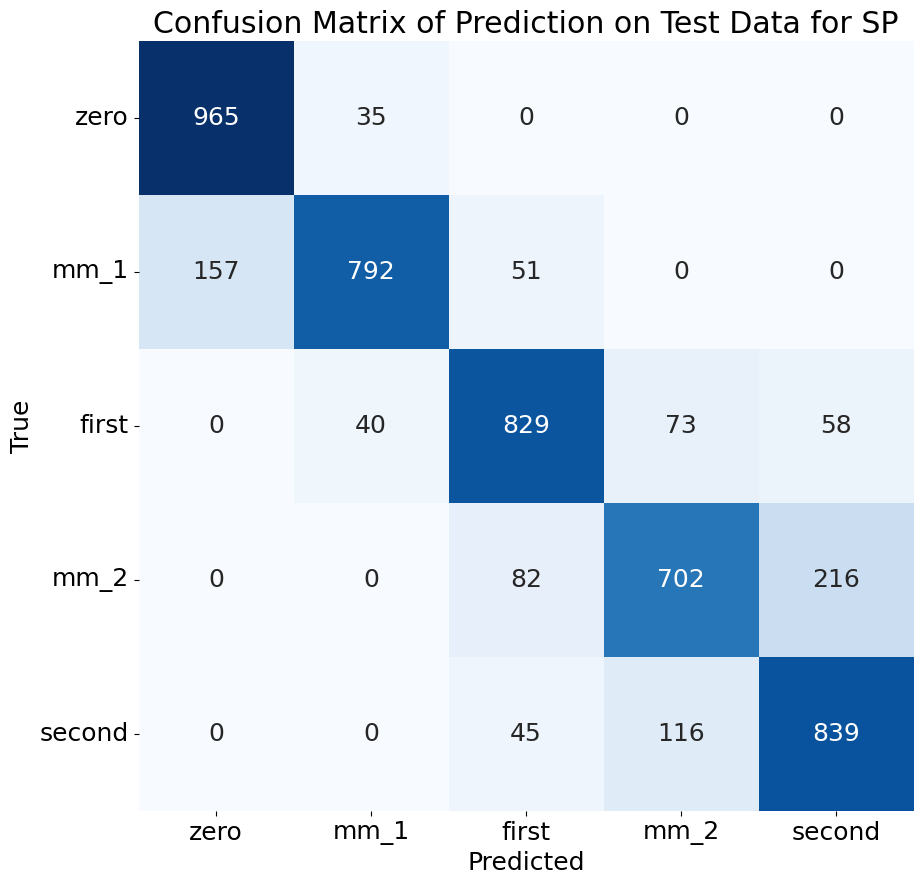

In [36]:
cm = skm.confusion_matrix(y_test, y_pred, labels=class_list)
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 18})
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
tick_marks = np.arange(len(class_list)) + 0.5
plt.xticks(tick_marks, class_list, rotation=0)
plt.yticks(tick_marks, class_list, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of Prediction on Test Data for SP')
# plt.title(f'CM of AG {cat_conc} / {sp_mode}')
plt.show()

In [37]:
from IPython.display import Image, display

path_to_png = predictor.plot_ensemble_model()
display(Image(filename=path_to_png))

In [38]:
# predictor.feature_importance(test_merge_data)

## norm_cat / s

In [4]:
cat_conc = 'norm_cat'
sp_mode = 's'

In [5]:
test_data_path = os.path.join(f'data/{cat_conc}', f'{cat_conc}_test_tsfresh_feat.csv')
test_data = pd.read_csv(test_data_path)
test_raw_data = pd.read_csv(os.path.join(f'data/{cat_conc}', f'{cat_conc}_test.csv'))
test_raw_data.drop(columns=['class'], inplace=True)
test_merge_data_sp = pd.merge(test_data, test_raw_data, on='id')
test_merge_data_s = test_merge_data_sp.drop(columns=[c for c in test_merge_data_sp.columns if c.startswith('p')])

if sp_mode == 'sp':
    test_merge_data = test_merge_data_sp
elif sp_mode == 's':
    test_merge_data = test_merge_data_s
else:
    raise ValueError('Wrong sp mode')


In [6]:

model_root = os.path.join(ag_model_root, f'{cat_conc}__tsfresh_raw_feat__{sp_mode}__best_quality__3h')

predictor = TabularPredictor.load(model_root)
predictor.leaderboard()

model  score_val eval_metric  pred_time_val  \
0           WeightedEnsemble_L3   0.788778    accuracy      83.246156   
1             LightGBMXT_BAG_L2   0.788467    accuracy      76.079173   
2               LightGBM_BAG_L2   0.788133    accuracy      76.004107   
3          LightGBMLarge_BAG_L2   0.787511    accuracy      76.377855   
4          LightGBM_r131_BAG_L2   0.787489    accuracy      76.044030   
5                XGBoost_BAG_L2   0.787467    accuracy      76.504684   
6            XGBoost_r33_BAG_L2   0.786133    accuracy      76.667705   
7            CatBoost_r9_BAG_L2   0.786022    accuracy      75.797027   
8         ExtraTreesEntr_BAG_L2   0.785956    accuracy      80.530410   
9           LightGBM_r96_BAG_L2   0.785622    accuracy      76.243452   
10      RandomForestEntr_BAG_L2   0.785533    accuracy      80.298996   
11      RandomForestGini_BAG_L2   0.785089    accuracy      80.395761   
12        ExtraTreesGini_BAG_L2   0.785089    accuracy      80.479186   
13          WeightedEnsemble_L2   0.785044    accuracy      20.096224   
14              CatBoost_BAG_L2   0.783889    accuracy      75.751168   
15       NeuralNetFastAI_BAG_L2   0.783733    accuracy      76.116129   
16  NeuralNetFastAI_r191_BAG_L2   0.783667    accuracy      76.401003   
17         CatBoost_r177_BAG_L2   0.783400    accuracy      75.754836   
18        NeuralNetTorch_BAG_L2   0.782044    accuracy      77.564497   
19    NeuralNetTorch_r79_BAG_L2   0.781756    accuracy      77.585476   
20         LightGBMLarge_BAG_L1   0.781622    accuracy       3.613058   
21    NeuralNetTorch_r22_BAG_L2   0.780933    accuracy      77.628596   
22        ExtraTrees_r42_BAG_L2   0.780733    accuracy      77.139729   
23         CatBoost_r137_BAG_L2   0.779400    accuracy      75.743116   
24         LightGBM_r131_BAG_L1   0.779289    accuracy       7.133780   
25          LightGBM_r96_BAG_L1   0.779111    accuracy      21.388524   
26            LightGBMXT_BAG_L1   0.778133    accuracy       3.298458   
27               XGBoost_BAG_L1   0.777711    accuracy       1.210293   
28              LightGBM_BAG_L1   0.777511    accuracy       1.814051   
29      RandomForestEntr_BAG_L1   0.775489    accuracy       3.986238   
30      RandomForestGini_BAG_L1   0.774578    accuracy       4.046390   
31           CatBoost_r9_BAG_L1   0.772578    accuracy       0.175199   
32         CatBoost_r177_BAG_L1   0.771356    accuracy       0.146464   
33              CatBoost_BAG_L1   0.771111    accuracy       0.140519   
34        ExtraTreesGini_BAG_L1   0.770089    accuracy       4.096087   
35        ExtraTreesEntr_BAG_L1   0.768867    accuracy       4.098379   
36        NeuralNetTorch_BAG_L1   0.766467    accuracy       1.259388   
37    NeuralNetTorch_r22_BAG_L1   0.764933    accuracy       1.298126   
38           XGBoost_r33_BAG_L1   0.762044    accuracy       0.694321   
39    NeuralNetTorch_r79_BAG_L1   0.761089    accuracy       1.276760   
40       NeuralNetFastAI_BAG_L1   0.755156    accuracy       0.457642   
41  NeuralNetFastAI_r191_BAG_L1   0.753111    accuracy       0.687204   
42        KNeighborsDist_BAG_L1   0.609244    accuracy       7.355232   
43        KNeighborsUnif_BAG_L1   0.607089    accuracy       7.443603   

       fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   5903.853377                0.002692           1.711158            3   
1   5380.136173                0.459459          62.157198            2   
2   5403.556016                0.384393          85.577041            2   
3   5601.761229                0.758141         283.782254            2   
4   5421.044511                0.424316         103.065536            2   
5   5425.219345                0.884969         107.240371            2   
6   5497.354778                1.047991         179.375804            2   
7   5869.501696                0.177313         551.522721            2   
8   5322.035858                4.910695           4.056883       

In [7]:
test_merge_data_nolabel = test_merge_data.drop(columns=['class'])
y_test = test_merge_data['class']
y_pred = predictor.predict(test_merge_data_nolabel)
y_proba = predictor.predict_proba(test_merge_data_nolabel)

In [8]:
df_test = pd.DataFrame(columns=['id', 'class', 'pred', 'proba'])
df_test['id'] = test_merge_data['id']
df_test['class'] = y_test
df_test['pred'] = y_pred
df_test['proba'] = y_proba.max(axis=1)
df_test['correct'] = df_test['class'] == df_test['pred']
df_test

id  class    pred     proba  correct
0     first-0__double-10024  first   first  0.644839     True
1     first-0__double-10076  first   first  0.695658     True
2     first-0__double-10113  first    mm_1  0.398905    False
3     first-0__double-10115  first   first  0.403888     True
4     first-0__double-10182  first  second  0.364572    False
...                     ...    ...     ...       ...      ...
4995    zero-0__single-9938   zero    zero  0.762043     True
4996    zero-0__single-9959   zero    zero  0.669368     True
4997    zero-0__single-9982   zero    zero  0.777630     True
4998    zero-0__single-9989   zero    zero  0.531317     True
4999    zero-0__single-9993   zero    zero  0.646427     True

[5000 rows x 5 columns]

In [9]:
train_val_raw_data = pd.read_csv(os.path.join(f'data/{cat_conc}', f'{cat_conc}_train_val.csv'))
# train_val_raw_data.drop(columns=['class'], inplace=True)
train_val_raw_data

id        s0        s1        s2        s3  \
0             second-1__double-6886  1.014078  0.941292  0.874194  0.831934   
1              mm_2-mm__double-8713  1.000000  0.857185  0.740969  0.644123   
2       first-0__double_outside-275  1.003719  0.943307  0.843800  0.748718   
3      first-0__double_outside-6283  1.000000  0.876857  0.769023  0.674643   
4       mm_2-mm__double_outside-288  0.992080  0.954080  0.862516  0.828265   
...                             ...       ...       ...       ...       ...   
44995           zero-0__single-4806  0.993863  0.967529  0.951562  0.930455   
44996           zero-0__single-8633  0.997781  0.964354  0.960647  0.908960   
44997          mm_2-mm__double-8171  0.987703  0.947029  0.888475  0.859816   
44998           zero-0__single-2474  1.000000  0.951507  0.912992  0.874481   
44999           first-0__double-349  1.017864  0.954688  0.895844  0.876814   

             s4        s5        s6        s7        s8  ...       p22  \
0      0.796985  0.752483  0.710213  0.682713  0.618944  ...  0.251490   
1      0.562685  0.493658  0.434723  0.384089  0.340341  ...  0.303795   
2      0.696003  0.690904  0.626570  0.550884  0.533442  ...  0.400171   
3      0.592040  0.519743  0.456460  0.401073  0.352590  ...  0.426240   
4      0.802843  0.746227  0.698473  0.675103  0.621021  ...  0.237389   
...         ...       ...       ...       ...       ...  ...       ...   
44995  0.918124  0.860564  0.856191  0.817006  0.869057  ...  0.569025   
44996  0.910344  0.866163  0.844907  0.852410  0.810318  ...  0.460265   
44997  0.774411  0.746599  0.702934  0.708254  0.643695  ...  0.317849   
44998  0.835976  0.797477  0.758982  0.720495  0.682016  ...  0.844814   
44999  0.842479  0.788048  0.764061  0.729272  0.702109  ...  0.236902   

            p23       p24       p25       p26       p27       p28       p29  \
0      0.255820  0.273534  0.269470  0.266760  0.267846  0.282937  0.281530   
1      0.304273  0.304664  0.304983  0.305245  0.305460  0.305636  0.305781   
2      0.394868  0.370069  0.398233  0.393137  0.419216  0.387829  0.406436   
3      0.429610  0.432611  0.435290  0.437688  0.439839  0.441774  0.443521   
4      0.260133  0.251989  0.260898  0.263738  0.270799  0.270729  0.291732   
...         ...       ...       ...       ...       ...       ...       ...   
44995  0.566647  0.578713  0.615658  0.600301  0.663694  0.655093  0.727246   
44996  0.513013  0.551517  0.568104  0.580049  0.598312  0.628465  0.652447   
44997  0.236502  0.284143  0.319657  0.304781  0.253440  0.272277  0.280512   
44998  0.882675  0.920217  0.956979  0.989495  0.999402  0.999973  0.999999   
44999  0.233330  0.240737  0.256784  0.253879  0.259333  0.286035  0.266107   

                old_class   class  
0               1__double  second  
1              mm__double    mm_2  
2       0__double_outside   first  
3       0__double_outside   first  
4      mm__double_outside    mm_2  
...                   ...     ...  
44995           0__single    zero  
44996           0__single    zero  
44997          mm__double    mm_2  
44998           0__single    zero  
44999           0__double   first  

[45000 rows x 63 columns]

In [10]:
accuracy = skm.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
balanced_accuracy = skm.balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')
precision = skm.precision_score(y_test, y_pred, average='macro')
print(f'Precision: {precision}')
recall = skm.recall_score(y_test, y_pred, average='macro')
print(f'Recall: {recall}')
f1 = skm.f1_score(y_test, y_pred, average='macro')
print(f'F1: {f1}')
roc_auc = skm.roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f'ROC AUC: {roc_auc}')
prc_auc = skm.average_precision_score(y_test, y_proba, average='macro')
print(f'PRC AUC: {prc_auc}')
mcc = skm.matthews_corrcoef(y_test, y_pred)
print(f'MCC: {mcc}')
top_2_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=2)
print(f'Top-2 Accuracy: {top_2_accuracy}')
top_3_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=3)
print(f'Top-3 Accuracy: {top_3_accuracy}')
print('================================')
print(skm.classification_report(y_test, y_pred))

Accuracy: 0.7872
Balanced Accuracy: 0.7872
Precision: 0.7859835406135394
Recall: 0.7872
F1: 0.7851125023950603
ROC AUC: 0.9642866250000001
PRC AUC: 0.8817651508085328
MCC: 0.7346556421288905
Top-2 Accuracy: 0.9594
Top-3 Accuracy: 0.9968
              precision    recall  f1-score   support

       first       0.77      0.80      0.78      1000
        mm_1       0.84      0.74      0.79      1000
        mm_2       0.70      0.66      0.68      1000
      second       0.77      0.77      0.77      1000
        zero       0.85      0.97      0.91      1000

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



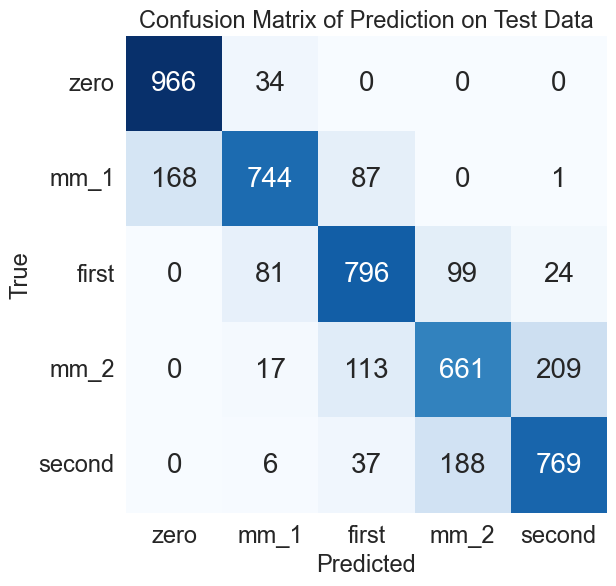

In [12]:
import matplotlib.font_manager as fm

cm = skm.confusion_matrix(y_test, y_pred, labels=class_list)
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6.2, 6.2))
plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(6, 6))
# plt.rcParams.update({'font.size': 24})
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
tick_marks = np.arange(len(class_list)) + 0.5
plt.xticks(tick_marks, class_list, rotation=0, fontsize=17)
plt.yticks(tick_marks, class_list, rotation=0, fontsize=17)
plt.xlabel('Predicted', fontsize=17)
plt.ylabel('True', fontsize=17)
plt.title(f'Confusion Matrix of Prediction on Test Data', fontsize=17)
# plt.title(f'CM of AG {cat_conc} / {sp_mode}')
plt.show()

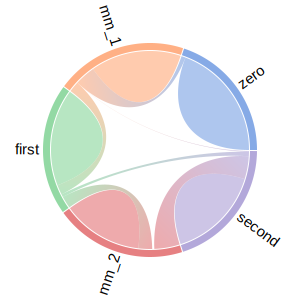

<Figure size 600x600 with 0 Axes>

In [13]:
import openchord as ocd

labels = ['zero', 'mm_1', 'first', 'mm_2', 'second']
plt.figure(figsize=(6, 6))
# for i in range(len(cm)):
#     cm[i][i] = 0
fig = ocd.Chord(cm, labels, radius=100)
fig.font_size = 15

# fig.colormap = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
fig.colormap = ['#79A1E3', '#FFA878', '#88D59A', '#E37275', '#AB9FD6']

# fig.show()
fig.show()

In [8]:
y_proba = y_proba[['zero', 'mm_1', 'first', 'mm_2', 'second']]
y_proba['class'] = y_test
y_proba

zero      mm_1     first      mm_2    second  class
0     0.058648  0.058837  0.644839  0.140862  0.096813  first
1     0.058273  0.112769  0.695658  0.071434  0.061866  first
2     0.076353  0.398905  0.344063  0.103350  0.077329  first
3     0.060134  0.400919  0.403888  0.070802  0.064257  first
4     0.063243  0.064604  0.147095  0.360486  0.364572  first
...        ...       ...       ...       ...       ...    ...
4995  0.762043  0.056071  0.055504  0.070749  0.055632   zero
4996  0.669368  0.154200  0.058695  0.058861  0.058876   zero
4997  0.777630  0.055604  0.055515  0.055621  0.055629   zero
4998  0.531317  0.288497  0.059999  0.060102  0.060085   zero
4999  0.646427  0.174845  0.059394  0.059667  0.059666   zero

[5000 rows x 6 columns]

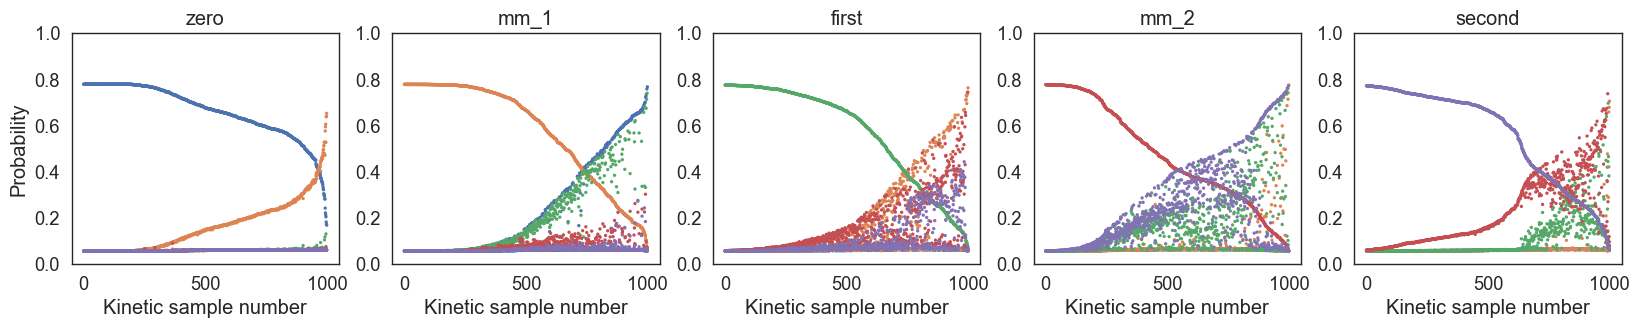

In [9]:
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'
# 5 figs
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
# zero
df_zero = y_proba[y_proba['class'] == 'zero']
df_zero = df_zero.sort_values(by=['zero', 'mm_1', 'first', 'mm_2', 'second'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_zero['zero'], ax=axes[0], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_zero['mm_1'], ax=axes[0], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_zero['first'], ax=axes[0], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_zero['mm_2'], ax=axes[0], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_zero['second'], ax=axes[0], legend=False, marker='.', edgecolor='none')
axes[0].set_title('zero')

# mm_1
df_mm_1 = y_proba[y_proba['class'] == 'mm_1']
df_mm_1 = df_mm_1.sort_values(by=['mm_1', 'first', 'mm_2', 'second', 'zero'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_mm_1['zero'], ax=axes[1], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_1['mm_1'], ax=axes[1], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_1['first'], ax=axes[1], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_1['mm_2'], ax=axes[1], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_1['second'], ax=axes[1], legend=False, marker='.', edgecolor='none')
axes[1].set_title('mm_1')

# first
df_first = y_proba[y_proba['class'] == 'first']
df_first = df_first.sort_values(by=['first', 'mm_2', 'second', 'zero', 'mm_1'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_first['zero'], ax=axes[2], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_first['mm_1'], ax=axes[2], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_first['first'], ax=axes[2], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_first['mm_2'], ax=axes[2], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_first['second'], ax=axes[2], legend=False, marker='.', edgecolor='none')
axes[2].set_title('first')

# mm_2
df_mm_2 = y_proba[y_proba['class'] == 'mm_2']
df_mm_2 = df_mm_2.sort_values(by=['mm_2', 'second', 'zero', 'mm_1', 'first'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_mm_2['zero'], ax=axes[3], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_2['mm_1'], ax=axes[3], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_2['first'], ax=axes[3], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_2['mm_2'], ax=axes[3], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_2['second'], ax=axes[3], legend=False, marker='.', edgecolor='none')
axes[3].set_title('mm_2')

# second
df_second = y_proba[y_proba['class'] == 'second']
df_second = df_second.sort_values(by=['second', 'zero', 'mm_1', 'first', 'mm_2'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_second['zero'], ax=axes[4], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_second['mm_1'], ax=axes[4], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_second['first'], ax=axes[4], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_second['mm_2'], ax=axes[4], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_second['second'], ax=axes[4], legend=False, marker='.', edgecolor='none')
axes[4].set_title('second')

# ylim
for ax in axes:
    ax.set_ylim(0, 1.0)
# no ylabel
for ax in axes[0:]:
    ax.set_ylabel('')
axes[0].set_ylabel('Probability')
for ax in axes:
    ax.set_xlabel('Kinetic sample number')

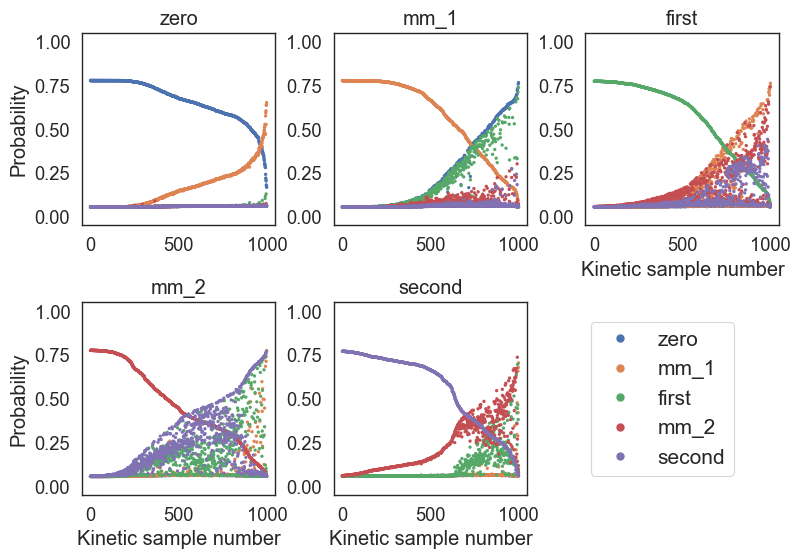

In [45]:
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'
# 5 figs
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()  # 将2D数组展平为1D，方便索引
from matplotlib.lines import Line2D

# zero
df_zero = y_proba[y_proba['class'] == 'zero']
df_zero = df_zero.sort_values(by=['zero', 'mm_1', 'first', 'mm_2', 'second'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_zero['zero'], ax=axes[0], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_zero['mm_1'], ax=axes[0], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_zero['first'], ax=axes[0], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_zero['mm_2'], ax=axes[0], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_zero['second'], ax=axes[0], legend=False, marker='.', edgecolor='none')
axes[0].set_title('zero')

# mm_1
df_mm_1 = y_proba[y_proba['class'] == 'mm_1']
df_mm_1 = df_mm_1.sort_values(by=['mm_1', 'first', 'mm_2', 'second', 'zero'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_mm_1['zero'], ax=axes[1], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_1['mm_1'], ax=axes[1], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_1['first'], ax=axes[1], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_1['mm_2'], ax=axes[1], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_1['second'], ax=axes[1], legend=False, marker='.', edgecolor='none')
axes[1].set_title('mm_1')

# first
df_first = y_proba[y_proba['class'] == 'first']
df_first = df_first.sort_values(by=['first', 'mm_2', 'second', 'zero', 'mm_1'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_first['zero'], ax=axes[2], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_first['mm_1'], ax=axes[2], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_first['first'], ax=axes[2], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_first['mm_2'], ax=axes[2], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_first['second'], ax=axes[2], legend=False, marker='.', edgecolor='none')
axes[2].set_title('first')

# mm_2
df_mm_2 = y_proba[y_proba['class'] == 'mm_2']
df_mm_2 = df_mm_2.sort_values(by=['mm_2', 'second', 'zero', 'mm_1', 'first'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_mm_2['zero'], ax=axes[3], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_2['mm_1'], ax=axes[3], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_2['first'], ax=axes[3], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_2['mm_2'], ax=axes[3], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_mm_2['second'], ax=axes[3], legend=False, marker='.', edgecolor='none')
axes[3].set_title('mm_2')

# second
df_second = y_proba[y_proba['class'] == 'second']
df_second = df_second.sort_values(by=['second', 'zero', 'mm_1', 'first', 'mm_2'], ascending=False).reset_index(drop=True)
sns.scatterplot(data=df_second['zero'], ax=axes[4], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_second['mm_1'], ax=axes[4], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_second['first'], ax=axes[4], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_second['mm_2'], ax=axes[4], legend=False, marker='.', edgecolor='none')
sns.scatterplot(data=df_second['second'], ax=axes[4], legend=False, marker='.', edgecolor='none')
axes[4].set_title('second')


# fig.delaxes(axes[-1])  # 删除多余的第六个子图
axes[-1].axis('off')  # 关闭第六个子图的坐标轴
custom_handles = [
    Line2D([0], [0], color='#4c72b0', marker='.', markersize=10, linestyle='none', label='zero'),
    Line2D([0], [0], color='#dd8452', marker='.', markersize=10, linestyle='none', label='mm_1'),
    Line2D([0], [0], color='#55a868', marker='.', markersize=10, linestyle='none', label='first'),
    Line2D([0], [0], color='#c44e52', marker='.', markersize=10, linestyle='none', label='mm_2'),
    Line2D([0], [0], color='#8172b3', marker='.', markersize=10, linestyle='none', label='second')
]
fig.legend(
    handles=custom_handles,
    loc='center',
    bbox_to_anchor=(0.72, 0.22, 0.1, 0.1),  # 图例位置调整
    fontsize=15,
    # title="Custom Legends",
    # title_fontsize=14
)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
# ylim
for ax in axes[:-1]:
    ax.set_ylim(-0.05, 1.05)
# no ylabel
for ax in axes[0:-1]:
    ax.set_ylabel('')
axes[0].set_ylabel('Probability')
axes[3].set_ylabel('Probability')
for ax in axes[2:-1]:
    ax.set_xlabel('Kinetic sample number')

In [27]:
df_mm_1

zero      mm_1     first      mm_2    second class
0    0.055571  0.777112  0.055683  0.055827  0.055806  mm_1
1    0.055576  0.777098  0.055684  0.055836  0.055806  mm_1
2    0.055573  0.777098  0.055684  0.055836  0.055809  mm_1
3    0.055578  0.777093  0.055685  0.055833  0.055810  mm_1
4    0.055589  0.777092  0.055682  0.055833  0.055805  mm_1
..        ...       ...       ...       ...       ...   ...
995  0.734220  0.090731  0.058246  0.058394  0.058408  mm_1
996  0.057642  0.090113  0.712238  0.074385  0.065621  mm_1
997  0.757274  0.073456  0.056331  0.056464  0.056474  mm_1
998  0.057631  0.070892  0.738846  0.071612  0.061019  mm_1
999  0.766526  0.065147  0.056019  0.056149  0.056158  mm_1

[1000 rows x 6 columns]

In [13]:
import matplotlib.font_manager as fm

# 获取所有字体路径
font_paths = fm.findSystemFonts()

# 检查是否能找到 Arial 字体
arial_fonts = [font for font in font_paths if 'Arial' in font]
print(arial_fonts)


['/usr/share/fonts/truetype/msttcorefonts/Arial_Black.ttf', '/usr/share/fonts/truetype/msttcorefonts/Arial_Bold.ttf', '/usr/share/fonts/truetype/msttcorefonts/Arial_Bold_Italic.ttf', '/usr/share/fonts/truetype/msttcorefonts/Arial_Italic.ttf', '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf']


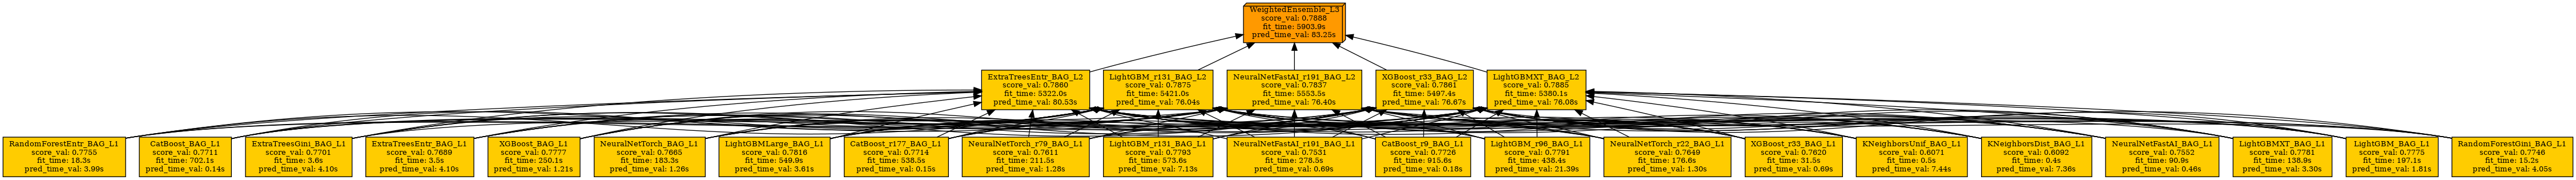

In [12]:
from IPython.display import Image, display

path_to_png = predictor.plot_ensemble_model()
display(Image(filename=path_to_png))

In [49]:
# feature_importance = predictor.feature_importance(test_merge_data)
# feature_importance

In [50]:
# feature_importance_dir = f'./feature_importance'
# if not os.path.exists(feature_importance_dir):
#     os.makedirs(feature_importance_dir)
# feature_importance.to_csv(f'./{feature_importance_dir}/{cat_conc}_{sp_mode}.csv')

## norm_cat/s/raw

In [1]:
cat_conc = 'norm_cat'
sp_mode = 's'

In [6]:
test_raw_data = pd.read_csv(os.path.join(f'data/{cat_conc}', f'{cat_conc}_test.csv'))
# test_raw_data.drop(columns=['class'], inplace=True)
test_merge_data_sp = test_raw_data
test_merge_data_s = test_raw_data.drop(columns=[c for c in test_raw_data.columns if c.startswith('p')])

if sp_mode == 'sp':
    test_merge_data = test_merge_data_sp
elif sp_mode == 's':
    test_merge_data = test_merge_data_s
else:
    raise ValueError('Wrong sp mode')

In [8]:
model_root = os.path.join(ag_model_root, f'{cat_conc}__raw_feat__{sp_mode}__best_quality__3h')

predictor = TabularPredictor.load(model_root)
predictor.leaderboard()

model  score_val eval_metric  pred_time_val  \
0             LightGBMXT_BAG_L2   0.772689    accuracy     412.840026   
1           WeightedEnsemble_L3   0.772689    accuracy     412.857450   
2               LightGBM_BAG_L2   0.772111    accuracy     413.951407   
3       RandomForestGini_BAG_L2   0.770622    accuracy     414.227541   
4       RandomForestEntr_BAG_L2   0.770022    accuracy     413.609692   
5        NeuralNetFastAI_BAG_L2   0.769933    accuracy     436.288192   
6           WeightedEnsemble_L2   0.765111    accuracy      10.222992   
7         NeuralNetTorch_BAG_L1   0.756644    accuracy       0.097713   
8     NeuralNetTorch_r22_BAG_L1   0.750822    accuracy       0.156150   
9         ExtraTrees_r42_BAG_L1   0.750400    accuracy       1.782571   
10              CatBoost_BAG_L2   0.747956    accuracy     411.532122   
11        ExtraTreesEntr_BAG_L1   0.745667    accuracy       1.131115   
12        ExtraTreesGini_BAG_L1   0.745400    accuracy       1.123639   
13      RandomForestEntr_BAG_L1   0.743933    accuracy       1.047442   
14    NeuralNetTorch_r79_BAG_L1   0.742422    accuracy       0.104463   
15      RandomForestGini_BAG_L1   0.742067    accuracy       1.021169   
16        KNeighborsDist_BAG_L1   0.741800    accuracy       0.960774   
17        KNeighborsUnif_BAG_L1   0.740533    accuracy       0.979207   
18         LightGBMLarge_BAG_L1   0.739911    accuracy       9.633628   
19  NeuralNetFastAI_r191_BAG_L1   0.739489    accuracy       0.329166   
20           XGBoost_r33_BAG_L1   0.738844    accuracy      31.018658   
21         LightGBM_r131_BAG_L1   0.737933    accuracy      62.070679   
22         CatBoost_r177_BAG_L1   0.736711    accuracy       0.135393   
23               XGBoost_BAG_L1   0.736400    accuracy       5.993648   
24           CatBoost_r9_BAG_L1   0.736289    accuracy       0.267570   
25       NeuralNetFastAI_BAG_L1   0.736089    accuracy       0.200192   
26  NeuralNetFastAI_r102_BAG_L1   0.735533    accuracy       0.173430   
27            LightGBMXT_BAG_L1   0.735333    accuracy      55.849669   
28              CatBoost_BAG_L1   0.735067    accuracy       0.138710   
29              LightGBM_BAG_L1   0.734467    accuracy       6.648235   
30          LightGBM_r96_BAG_L1   0.731311    accuracy     220.395243   
31     RandomForest_r195_BAG_L1   0.729867    accuracy       0.495830   
32         CatBoost_r137_BAG_L1   0.727378    accuracy       0.406005   
33         LightGBM_r188_BAG_L1   0.685489    accuracy       5.775534   
34          CatBoost_r13_BAG_L1   0.630933    accuracy       1.112617   

       fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   5947.755313                3.791577         654.375375            2   
1   5952.525633                0.017424           4.770320            3   
2   5757.556562                4.902958         464.176624            2   
3   5313.567940                5.179092          20.188001            2   
4   5314.974297                4.561243          21.594358            2   
5   6632.735671               27.239743        1339.355732            2   
6    939.745786                0.004035           3.014494            2   
7    253.297797                0.097713         253.297797            1   
8    399.977010                0.156150         399.977010            1   
9      2.555269                1.782571           2.555269            1   
10  5461.256166                2.483673         167.876228            2   
11     0.932017                1.131115           0.932017            1   
12     0.924969                1.123639           0.924969            1   
13     6.245463                1.047442           6.245463            1   
14   204.139814                0.104463         204.139814            1   
15     4.733631                1.021169           4.733631            1   
16     0.039893                0.960774           0.039893            1   
17     0.047182                0.979207        

In [9]:
test_merge_data_nolabel = test_merge_data.drop(columns=['class'])
y_test = test_merge_data['class']
y_pred = predictor.predict(test_merge_data_nolabel)
y_proba = predictor.predict_proba(test_merge_data_nolabel)

In [10]:
accuracy = skm.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
balanced_accuracy = skm.balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')
precision = skm.precision_score(y_test, y_pred, average='macro')
print(f'Precision: {precision}')
recall = skm.recall_score(y_test, y_pred, average='macro')
print(f'Recall: {recall}')
f1 = skm.f1_score(y_test, y_pred, average='macro')
print(f'F1: {f1}')
roc_auc = skm.roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f'ROC AUC: {roc_auc}')
prc_auc = skm.average_precision_score(y_test, y_proba, average='macro')
print(f'PRC AUC: {prc_auc}')
mcc = skm.matthews_corrcoef(y_test, y_pred)
print(f'MCC: {mcc}')
top_2_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=2)
print(f'Top-2 Accuracy: {top_2_accuracy}')
top_3_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=3)
print(f'Top-3 Accuracy: {top_3_accuracy}')
print('================================')
print(skm.classification_report(y_test, y_pred))

Accuracy: 0.772
Balanced Accuracy: 0.772
Precision: 0.7705115141112422
Recall: 0.772
F1: 0.7702707568618986
ROC AUC: 0.959123
PRC AUC: 0.8668876871208144
MCC: 0.7154347587140152
Top-2 Accuracy: 0.9484
Top-3 Accuracy: 0.9972
              precision    recall  f1-score   support

       first       0.74      0.77      0.75      1000
        mm_1       0.82      0.75      0.78      1000
        mm_2       0.68      0.66      0.67      1000
      second       0.76      0.74      0.75      1000
        zero       0.85      0.95      0.90      1000

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



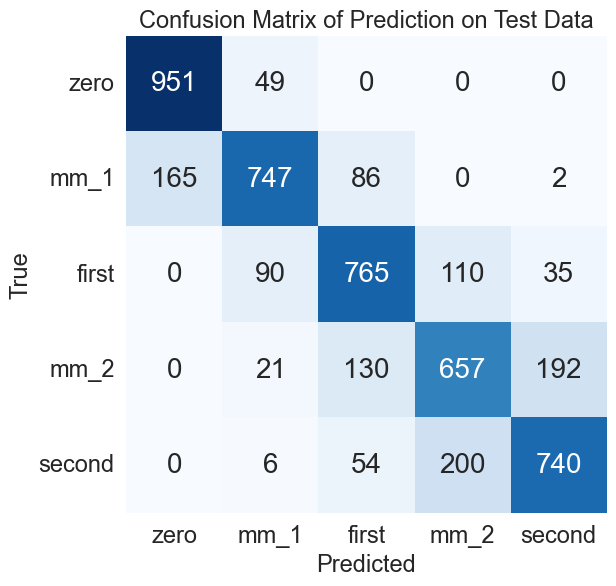

In [11]:
import matplotlib.font_manager as fm

cm = skm.confusion_matrix(y_test, y_pred, labels=class_list)
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6.2, 6.2))
plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(6, 6))
# plt.rcParams.update({'font.size': 24})
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
tick_marks = np.arange(len(class_list)) + 0.5
plt.xticks(tick_marks, class_list, rotation=0, fontsize=17)
plt.yticks(tick_marks, class_list, rotation=0, fontsize=17)
plt.xlabel('Predicted', fontsize=17)
plt.ylabel('True', fontsize=17)
plt.title(f'Confusion Matrix of Prediction on Test Data', fontsize=17)
# plt.title(f'CM of AG {cat_conc} / {sp_mode}')
plt.show()

## norm_cat/s/tsfresh

In [12]:
cat_conc = 'norm_cat'
sp_mode = 's'

In [13]:
test_data_path = os.path.join(f'data/{cat_conc}', f'{cat_conc}_test_tsfresh_feat.csv')
test_data = pd.read_csv(test_data_path)
test_merge_data_sp = test_data
test_merge_data_s = test_data.drop(columns=[c for c in test_data.columns if c.startswith('p')])

if sp_mode == 'sp':
    test_merge_data = test_merge_data_sp
elif sp_mode == 's':
    test_merge_data = test_merge_data_s
else:
    raise ValueError('Wrong sp mode')

In [14]:

model_root = os.path.join(ag_model_root, f'{cat_conc}__tsfresh_feat__{sp_mode}__best_quality__3h')

predictor = TabularPredictor.load(model_root)
predictor.leaderboard()

model  score_val eval_metric  pred_time_val  \
0           WeightedEnsemble_L3   0.789156    accuracy     104.867163   
1             LightGBMXT_BAG_L2   0.787822    accuracy      88.497658   
2          LightGBM_r131_BAG_L2   0.787689    accuracy      88.548867   
3       RandomForestEntr_BAG_L2   0.787533    accuracy      92.940876   
4               LightGBM_BAG_L2   0.787156    accuracy      88.398194   
5            XGBoost_r33_BAG_L2   0.786978    accuracy      88.959038   
6                XGBoost_BAG_L2   0.786733    accuracy      89.049413   
7       RandomForestGini_BAG_L2   0.786533    accuracy      92.879194   
8          LightGBMLarge_BAG_L2   0.786178    accuracy      88.523226   
9           LightGBM_r96_BAG_L2   0.785911    accuracy      88.911837   
10           CatBoost_r9_BAG_L2   0.785378    accuracy      88.183977   
11        ExtraTreesEntr_BAG_L2   0.785311    accuracy      93.026905   
12        ExtraTreesGini_BAG_L2   0.784622    accuracy      93.022598   
13          WeightedEnsemble_L2   0.784378    accuracy      29.253168   
14              CatBoost_BAG_L2   0.784267    accuracy      88.178727   
15         CatBoost_r177_BAG_L2   0.783622    accuracy      88.156043   
16       NeuralNetFastAI_BAG_L2   0.783400    accuracy      88.601691   
17  NeuralNetFastAI_r191_BAG_L2   0.782933    accuracy      88.865166   
18    NeuralNetTorch_r79_BAG_L2   0.781733    accuracy      89.772285   
19        NeuralNetTorch_BAG_L2   0.781489    accuracy      89.809360   
20         LightGBMLarge_BAG_L1   0.781178    accuracy       2.898827   
21        ExtraTrees_r42_BAG_L2   0.780222    accuracy      89.435686   
22    NeuralNetTorch_r22_BAG_L2   0.780222    accuracy      89.772542   
23         CatBoost_r137_BAG_L2   0.779333    accuracy      88.141884   
24            LightGBMXT_BAG_L1   0.778800    accuracy      14.596410   
25               XGBoost_BAG_L1   0.778689    accuracy       1.801367   
26              LightGBM_BAG_L1   0.778089    accuracy       1.984590   
27      RandomForestEntr_BAG_L1   0.775911    accuracy       8.514740   
28      RandomForestGini_BAG_L1   0.775333    accuracy       8.945822   
29              CatBoost_BAG_L1   0.770067    accuracy       0.317763   
30         CatBoost_r177_BAG_L1   0.769356    accuracy       0.162081   
31        ExtraTreesEntr_BAG_L1   0.768356    accuracy       4.528913   
32        ExtraTreesGini_BAG_L1   0.768156    accuracy       4.534407   
33        NeuralNetTorch_BAG_L1   0.766667    accuracy       1.304674   
34    NeuralNetTorch_r79_BAG_L1   0.747267    accuracy       1.313270   
35         LightGBM_r131_BAG_L1   0.744578    accuracy       0.134431   
36        KNeighborsDist_BAG_L1   0.608867    accuracy      18.173335   
37        KNeighborsUnif_BAG_L1   0.606978    accuracy      18.822289   

       fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   5777.374378                0.002902           1.913188            3   
1   4803.923406                0.464737          63.220025            2   
2   4841.148340                0.515946         100.444958            2   
3   4759.492484                4.907955          18.789102            2   
4   4825.146973                0.365273          84.443592            2   
5   4891.015413                0.926117         150.312032            2   
6   4868.643431                1.016492         127.940050            2   
7   4757.643234                4.846273          16.939853            2   
8   4958.126133                0.490305         217.422752            2   
9   4793.772238                0.878916          53.068856            2   
10  5190.921499                0.151056         450.218117            2   
11  4744.819676                4.993984           4.116295            2   
12  4744.828315                4.989676           4.124934            2   
13  2812.288258                0.002719           1.090535            2   
14  4908.003594                0.145806         167.3

In [15]:
test_merge_data_nolabel = test_merge_data.drop(columns=['class'])
y_test = test_merge_data['class']
y_pred = predictor.predict(test_merge_data_nolabel)
y_proba = predictor.predict_proba(test_merge_data_nolabel)

In [16]:
accuracy = skm.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
balanced_accuracy = skm.balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')
precision = skm.precision_score(y_test, y_pred, average='macro')
print(f'Precision: {precision}')
recall = skm.recall_score(y_test, y_pred, average='macro')
print(f'Recall: {recall}')
f1 = skm.f1_score(y_test, y_pred, average='macro')
print(f'F1: {f1}')
roc_auc = skm.roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f'ROC AUC: {roc_auc}')
prc_auc = skm.average_precision_score(y_test, y_proba, average='macro')
print(f'PRC AUC: {prc_auc}')
mcc = skm.matthews_corrcoef(y_test, y_pred)
print(f'MCC: {mcc}')
top_2_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=2)
print(f'Top-2 Accuracy: {top_2_accuracy}')
top_3_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=3)
print(f'Top-3 Accuracy: {top_3_accuracy}')
print('================================')
print(skm.classification_report(y_test, y_pred))

Accuracy: 0.7874
Balanced Accuracy: 0.7874
Precision: 0.785989877975866
Recall: 0.7874
F1: 0.7854315000664223
ROC AUC: 0.9641652000000001
PRC AUC: 0.8816726837833132
MCC: 0.7348124938128009
Top-2 Accuracy: 0.9584
Top-3 Accuracy: 0.997
              precision    recall  f1-score   support

       first       0.77      0.80      0.78      1000
        mm_1       0.84      0.75      0.79      1000
        mm_2       0.69      0.66      0.68      1000
      second       0.77      0.77      0.77      1000
        zero       0.86      0.96      0.91      1000

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



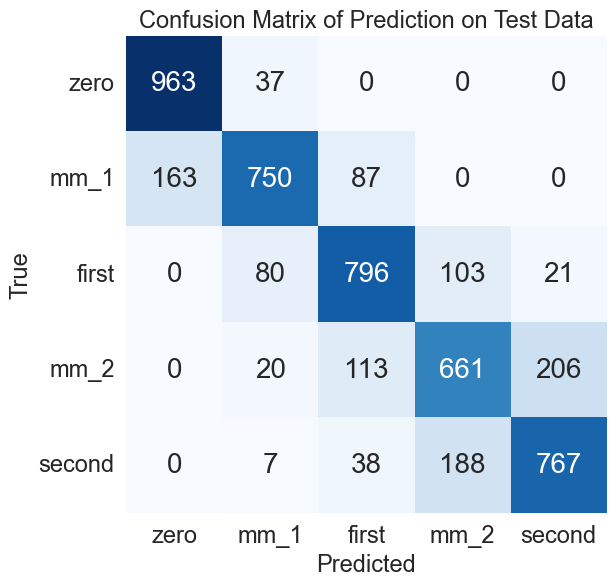

In [17]:
import matplotlib.font_manager as fm

cm = skm.confusion_matrix(y_test, y_pred, labels=class_list)
sns.set_theme(style="white")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6.2, 6.2))
plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(6, 6))
# plt.rcParams.update({'font.size': 24})
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
tick_marks = np.arange(len(class_list)) + 0.5
plt.xticks(tick_marks, class_list, rotation=0, fontsize=17)
plt.yticks(tick_marks, class_list, rotation=0, fontsize=17)
plt.xlabel('Predicted', fontsize=17)
plt.ylabel('True', fontsize=17)
plt.title(f'Confusion Matrix of Prediction on Test Data', fontsize=17)
# plt.title(f'CM of AG {cat_conc} / {sp_mode}')
plt.show()

## norm_cat / p

In [51]:
cat_conc = 'norm_cat'
sp_mode = 'p'

In [52]:
test_data_path = os.path.join(f'data/{cat_conc}', f'{cat_conc}_test_tsfresh_feat.csv')
test_data = pd.read_csv(test_data_path)
test_raw_data = pd.read_csv(os.path.join(f'data/{cat_conc}', f'{cat_conc}_test.csv'))
test_raw_data.drop(columns=['class'], inplace=True)
test_merge_data_sp = pd.merge(test_data, test_raw_data, on='id', how='inner')
test_merge_data_s = test_merge_data_sp.drop(columns=[c for c in test_merge_data_sp.columns if c.startswith('p')])
test_merge_data_p = test_merge_data_sp.drop(columns=[c for c in test_merge_data_sp.columns if c.startswith('s')])

if sp_mode == 'sp':
    test_merge_data = test_merge_data_sp
elif sp_mode == 's':
    test_merge_data = test_merge_data_s
elif sp_mode == 'p':
    test_merge_data = test_merge_data_p
else:
    raise ValueError('Wrong sp mode')

model_root = os.path.join(ag_model_root, f'{cat_conc}__tsfresh_raw_feat__{sp_mode}__best_quality')

predictor = TabularPredictor.load(model_root)
predictor.leaderboard()

model  score_val eval_metric  pred_time_val  \
0          LightGBM_r131_BAG_L2   0.764067    accuracy      15.174907   
1           WeightedEnsemble_L3   0.764067    accuracy      15.177463   
2          LightGBMLarge_BAG_L2   0.763822    accuracy      15.767356   
3            CatBoost_r9_BAG_L2   0.763378    accuracy      15.097524   
4             LightGBMXT_BAG_L2   0.763244    accuracy      15.231576   
5               LightGBM_BAG_L2   0.762844    accuracy      15.083323   
6           WeightedEnsemble_L2   0.762600    accuracy       4.885694   
7           LightGBM_r96_BAG_L2   0.762356    accuracy      15.062036   
8          LightGBMLarge_BAG_L1   0.762311    accuracy       2.894654   
9          CatBoost_r177_BAG_L2   0.762200    accuracy      15.050203   
10              CatBoost_BAG_L2   0.762044    accuracy      15.042946   
11         LightGBM_r131_BAG_L1   0.760911    accuracy       3.051657   
12         CatBoost_r137_BAG_L2   0.760311    accuracy      15.073706   
13            LightGBMXT_BAG_L1   0.759778    accuracy       1.836345   
14              LightGBM_BAG_L1   0.759089    accuracy       0.806440   
15         CatBoost_r177_BAG_L1   0.754600    accuracy       0.239725   
16              CatBoost_BAG_L1   0.754444    accuracy       0.258320   
17          LightGBM_r96_BAG_L1   0.752556    accuracy       3.613217   
18           CatBoost_r9_BAG_L1   0.750311    accuracy       0.224222   
19         CatBoost_r137_BAG_L1   0.634644    accuracy       0.151822   
20       NeuralNetFastAI_BAG_L1   0.200000    accuracy       0.581107   
21  NeuralNetFastAI_r191_BAG_L1   0.200000    accuracy       1.145499   
22       NeuralNetFastAI_BAG_L2   0.200000    accuracy      15.417879   
23  NeuralNetFastAI_r191_BAG_L2   0.200000    accuracy      16.037352   

       fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   3594.342397                0.371900          83.178304            2   
1   3598.409685                0.002556           4.067288            3   
2   3830.509619                0.964348         319.345526            2   
3   3875.944903                0.294517         364.780811            2   
4   3574.481953                0.428569          63.317860            2   
5   3596.096864                0.280316          84.932771            2   
6    686.012722                0.002872           3.342919            2   
7   3545.831574                0.259028          34.667482            2   
8    549.804064                2.894654         549.804064            1   
9   3691.988114                0.247196         180.824022            2   
10  3645.196134                0.239938         134.032041            2   
11   278.009038                3.051657         278.009038            1   
12  3560.763619                0.270698          49.599526            2   
13   124.551004                1.836345         124.551004            1   
14   124.532978                0.806440         124.532978            1   
15   704.969936                0.239725         704.969936            1   
16   819.697343                0.258320         819.697343            1   
17    87.356174                3.613217          87.356174            1   
18   422.002522                0.224222         422.002522            1   
19     8.314734                0.151822           8.314734            1   
20   111.100636                0.581107         111.100636            1   
21   280.825664                1.145499         280.825664            1   
22  3626.616628                0.614872         115.452535            2   
23  3795.199176                1.234344         284.035083            2   

    can_infer  fit_order  
0        True         19  
1        True         24  
2        True         17  
3        True         21  
4        True         14  
5        True         15  
6        True         12  
7        True         22  
8        True          5  
9        True         18  
10       True         16  


In [53]:
test_merge_data_nolabel = test_merge_data.drop(columns=['class'])
y_test = test_merge_data['class']
y_pred = predictor.predict(test_merge_data_nolabel)
y_proba = predictor.predict_proba(test_merge_data_nolabel)

/home/zxhuang/anaconda3/envs/my_org_mech/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, downcast=False)
/home/zxhuang/anaconda3/envs/my_org_mech/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:180: RuntimeWarning: invalid value encountered in subtract
  (X[self.cont_columns].values - cont_mean) / cont_std,
/home/zxhuang/anaconda3/envs/my_org_mech/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast'

In [54]:
accuracy = skm.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
balanced_accuracy = skm.balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_accuracy}')
precision = skm.precision_score(y_test, y_pred, average='macro')
print(f'Precision: {precision}')
recall = skm.recall_score(y_test, y_pred, average='macro')
print(f'Recall: {recall}')
f1 = skm.f1_score(y_test, y_pred, average='macro')
print(f'F1: {f1}')
roc_auc = skm.roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f'ROC AUC: {roc_auc}')
prc_auc = skm.average_precision_score(y_test, y_proba, average='macro')
print(f'PRC AUC: {prc_auc}')
mcc = skm.matthews_corrcoef(y_test, y_pred)
print(f'MCC: {mcc}')
top_2_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=2)
print(f'Top-2 Accuracy: {top_2_accuracy}')
top_3_accuracy = skm.top_k_accuracy_score(y_test, y_proba, k=3)
print(f'Top-3 Accuracy: {top_3_accuracy}')
print('================================')
print(skm.classification_report(y_test, y_pred))

Accuracy: 0.7702
Balanced Accuracy: 0.7702
Precision: 0.7752077487069938
Recall: 0.7702
F1: 0.7678912271960203
ROC AUC: 0.9570770749999999
PRC AUC: 0.8584003442566571
MCC: 0.7151844473904824
Top-2 Accuracy: 0.9606
Top-3 Accuracy: 1.0
              precision    recall  f1-score   support

       first       0.80      0.71      0.75      1000
        mm_1       0.91      0.78      0.84      1000
        mm_2       0.66      0.57      0.61      1000
      second       0.65      0.82      0.73      1000
        zero       0.85      0.97      0.91      1000

    accuracy                           0.77      5000
   macro avg       0.78      0.77      0.77      5000
weighted avg       0.78      0.77      0.77      5000



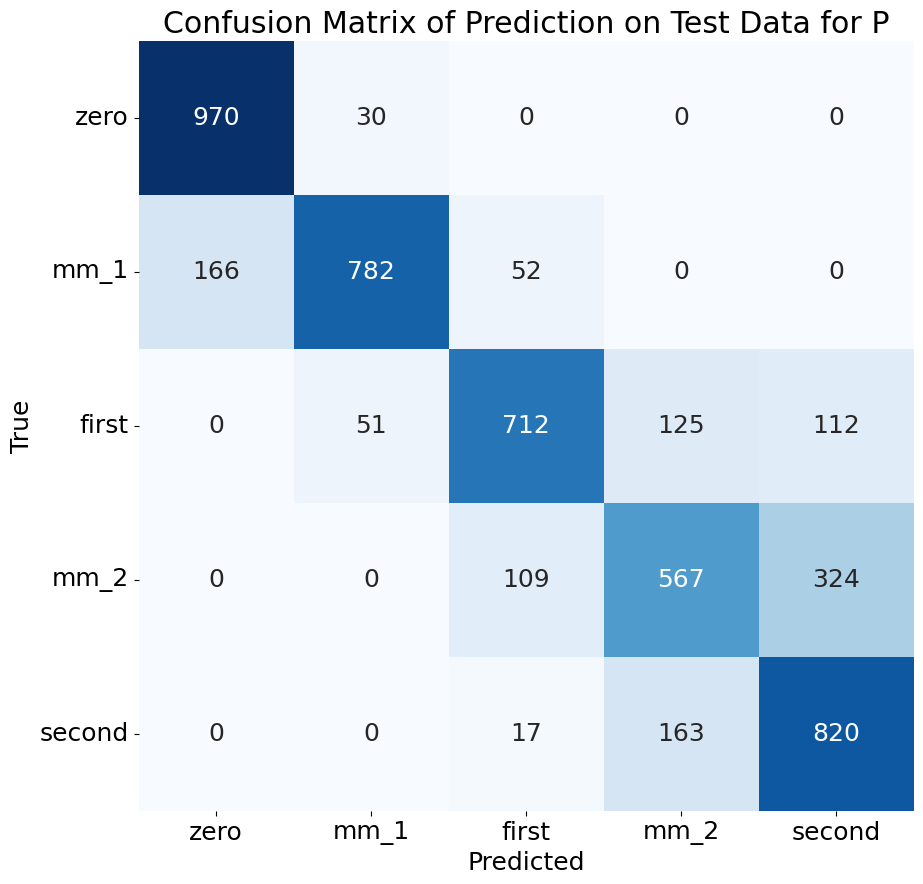

In [55]:
cm = skm.confusion_matrix(y_test, y_pred, labels=class_list)
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 18})
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
tick_marks = np.arange(len(class_list)) + 0.5
plt.xticks(tick_marks, class_list, rotation=0)
plt.yticks(tick_marks, class_list, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of Prediction on Test Data for P')
# plt.title(f'CM of AG {cat_conc} / {sp_mode}')
plt.show()

## test how to draw a line with std

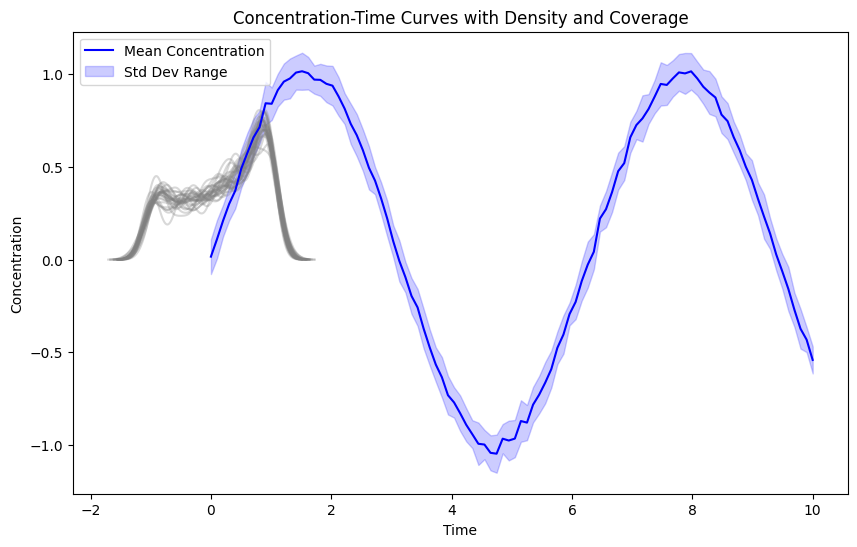

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 生成示例数据
np.random.seed(42)
time_points = np.linspace(0, 10, 100)
num_curves = 30
concentration_curves = [np.sin(time_points) + np.random.normal(scale=0.1, size=time_points.shape) for _ in range(num_curves)]

# 转换为numpy数组
concentration_curves = np.array(concentration_curves)

# 计算均值和标准差
mean_concentration = np.mean(concentration_curves, axis=0)
std_concentration = np.std(concentration_curves, axis=0)

# 绘制曲线
plt.figure(figsize=(10, 6))

# 使用seaborn的kdeplot展示密度
for curve in concentration_curves:
    sns.kdeplot(curve, bw_adjust=0.5, color='gray', alpha=0.3)

# 绘制均值曲线
plt.plot(time_points, mean_concentration, color='blue', label='Mean Concentration')

# 绘制标准差范围
plt.fill_between(time_points, mean_concentration - std_concentration, mean_concentration + std_concentration, color='blue', alpha=0.2, label='Std Dev Range')

# 设置图例和标签
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration-Time Curves with Density and Coverage')

# 显示图像
plt.show()
